# Задача 3. Posterior Sampling в задаче RL

Большая задача на разбор статьи. Требуется решить проблемы "Задачи о заплыве" связанные с тем, что алгоритм не доходит до левого края и начинает всегда скатываться по течению.

P.S. Реализируйте метод Posterior Sampling из статьи.

P.S.S. Рекомендую посмотреть часть семинара sem-25 связаной с данной проблемой.

In [1]:
from abc import abstractmethod

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torch
from scipy.stats import gamma, norm, dirichlet

from torch.utils.tensorboard import SummaryWriter

# Задача о заплыве

In [2]:
class RiverSwim:
    def __init__(self,
                 isc  = 4, # число состояний (без учета крайних)
                 ms   = 16, # максимальное число шагов
                 lr   = 5/1000,
                 rr   = 1.0,
                 seed = 42):
        self.rs = np.random.RandomState(seed)
        self._max_steps = ms
        self._interm_states = isc

        self._steps = 0
        self._current_state = 1

        self.lr = lr
        self.rr = rr

    @property
    def action_count(self):
        return 2

    @property
    def states_count(self):
        return 2 + self._interm_states

    def _get_probs(self, action):
        if action == 0:
            if self._current_state == 0:
                return [0.00, 1.00, 0.00]
            else:
                return [1.00, 0.00, 0.00]

        elif action == 1:
            if self._current_state == 0:
                return [0.00, 0.40, 0.60]
            if self._current_state == self.states_count - 1:
                return [0.40, 0.60, 0.00]
            else:
                return [0.05, 0.60, 0.35]

    def step(self, action):
        reward = 0.0
        if self._steps >= self._max_steps:
            return self._current_state, reward, True

        transition = self.rs.choice(range(3), p=self._get_probs(action))
        if transition == 0:
            self._current_state -= 1
        elif transition == 1:
            pass
        else:
            self._current_state += 1

        if self._current_state == 0:
            reward = self.lr
        elif self._current_state == self.states_count - 1:
            reward = self.rr

        self._steps += 1
        return self._current_state, reward, False

In [ ]:
class QLearningAgent:
    def __init__(self, n, K, lr=0.2, gamma=0.95, epsilon=0.2, seed=42):
        self.rs = np.random.RandomState(seed)
        self._gamma = gamma
        self._epsilon = epsilon
        self._q_matrix = np.zeros((n, K))
        self._lr = lr

    def get_action(self, state):
        if self.rs.random() < self._epsilon:
            return self.rs.randint(0, self._q_matrix.shape[1])
        else:
            return np.argmax(self._q_matrix[state])

    def get_q_matrix(self):
        return self._q_matrix

    def start_episode(self):
        pass

    def update(self, state, action, reward, next_state):
        self._q_matrix[state, action] = self._q_matrix[state, action] + self._lr*(reward + self._gamma*np.max(self._q_matrix[next_state]) - self._q_matrix[state, action])
        return


## Для начала проверим что проблема действительно есть
запустим для разных n

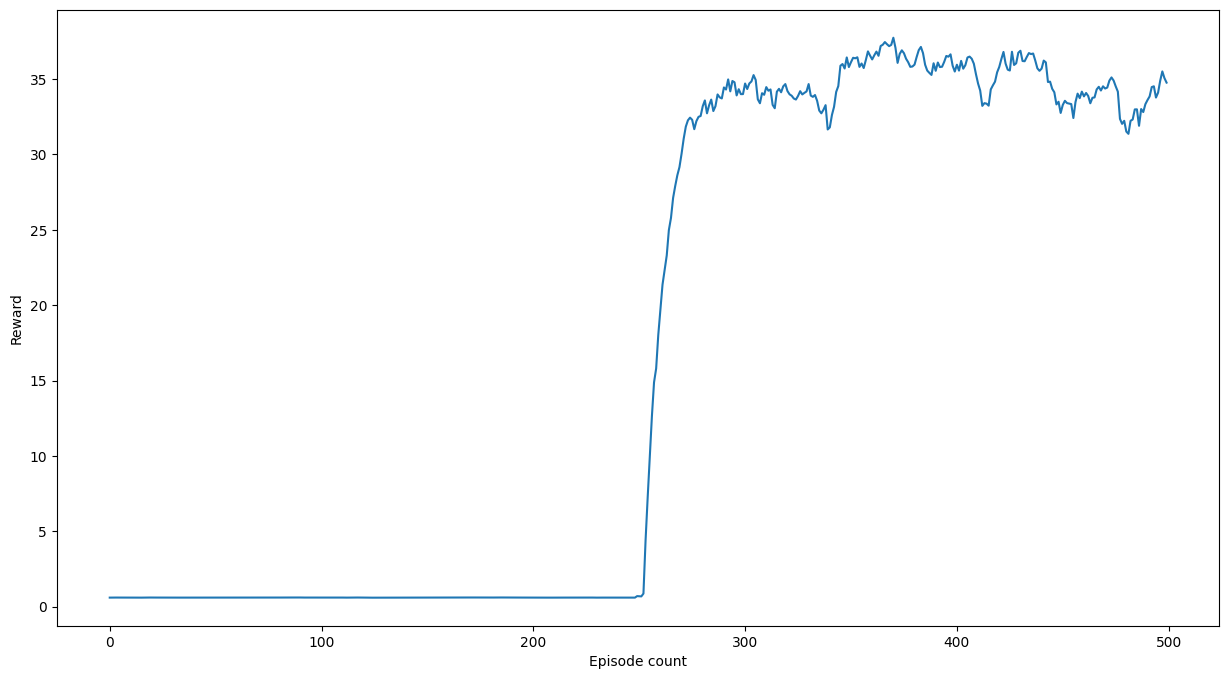

In [ ]:
n = 2
ms = 128
episodes = 500
actions = 2

agent = QLearningAgent(2+n, actions)

episode_rewards = []
for ep in range(episodes):
    river_swim = RiverSwim(n, ms)

    state, ep_reward, is_done = river_swim._current_state, 0.0, False
    agent.start_episode()
    while not is_done:
        action = agent.get_action(state)
        next_state, reward, is_done = river_swim.step(action)
        agent.update(state, action, reward, next_state)

        state = next_state
        ep_reward += reward

    episode_rewards.append(ep_reward)


plt.figure(figsize=(15, 8))

plt.plot(pd.DataFrame(np.array(episode_rewards)).ewm(alpha=.1).mean())
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

<ipython-input-18-3c99130bf45b>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'no act', 'swim'])


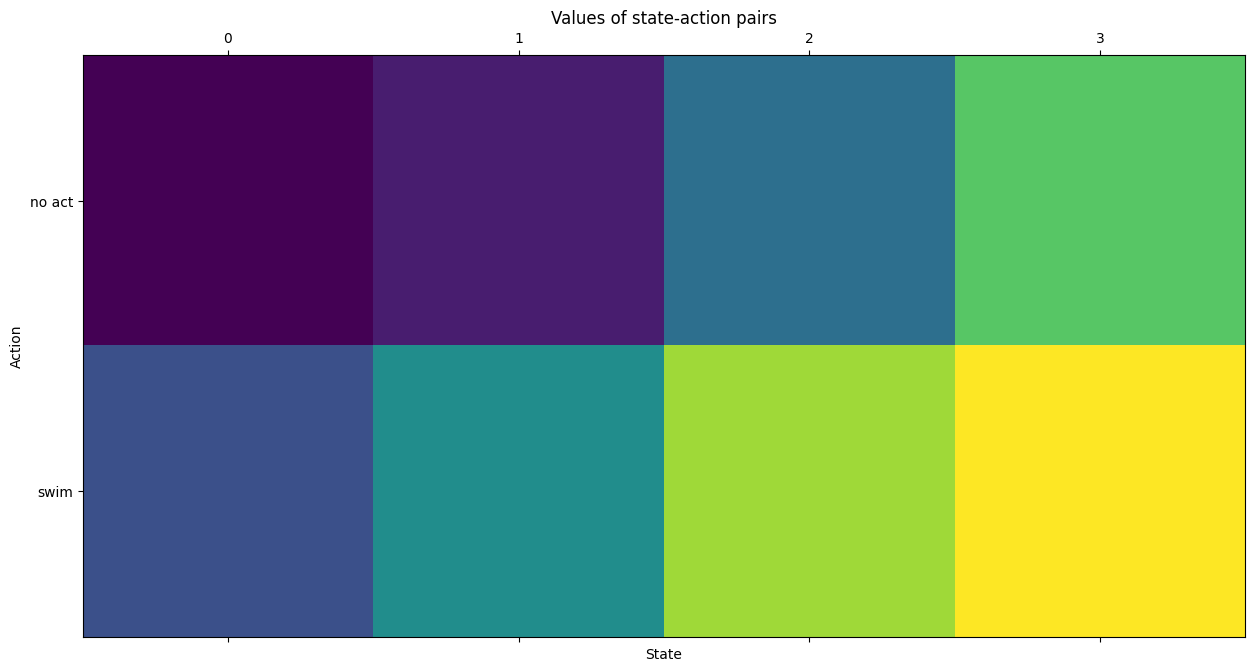

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.matshow(agent.get_q_matrix().T)
ax.set_yticklabels(['', 'no act', 'swim'])
plt.xlabel("State")
plt.ylabel("Action")
plt.title("Values of state-action pairs")
plt.show()

Здесь всё как надо,выирышная стратегия доплыть до конца и оставаться и последнем состоянии

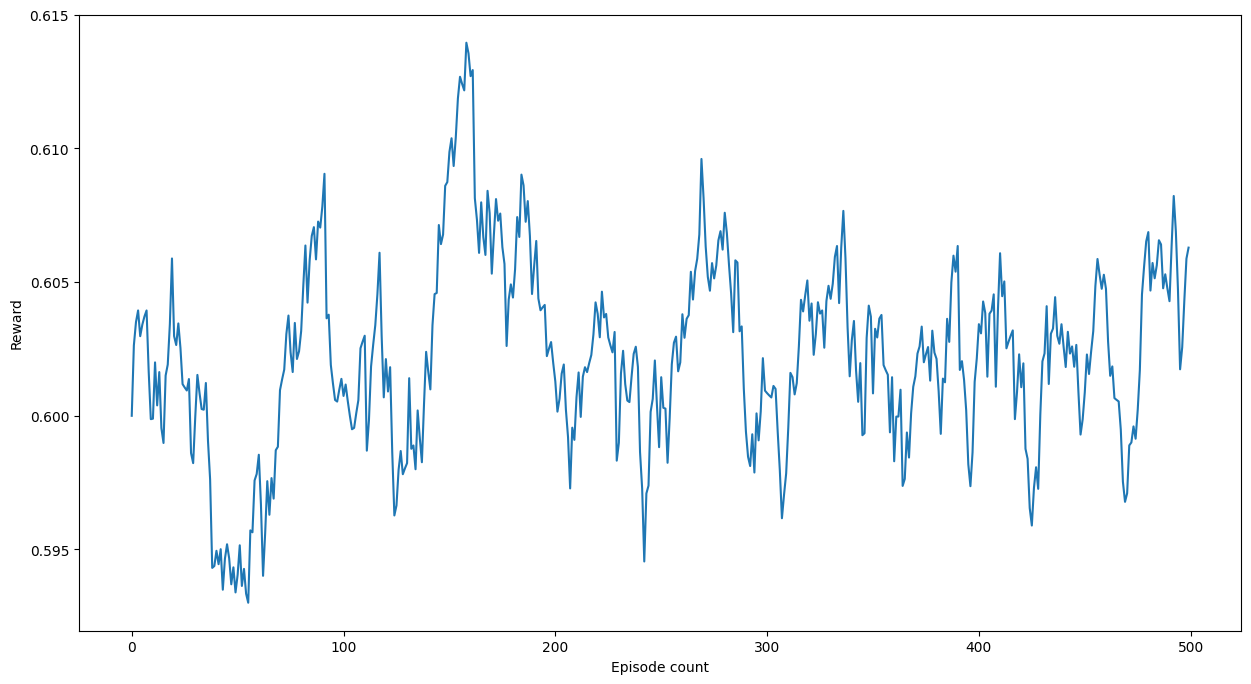

In [ ]:
n = 4
ms = 128
episodes = 500
actions = 2

agent = QLearningAgent(2+n, actions)

episode_rewards = []
for ep in range(episodes):
    river_swim = RiverSwim(n, ms)

    state, ep_reward, is_done = river_swim._current_state, 0.0, False
    agent.start_episode()
    while not is_done:
        action = agent.get_action(state)
        next_state, reward, is_done = river_swim.step(action)
        agent.update(state, action, reward, next_state)

        state = next_state
        ep_reward += reward

    episode_rewards.append(ep_reward)


plt.figure(figsize=(15, 8))

plt.plot(pd.DataFrame(np.array(episode_rewards)).ewm(alpha=.1).mean())
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

<ipython-input-20-3c99130bf45b>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'no act', 'swim'])


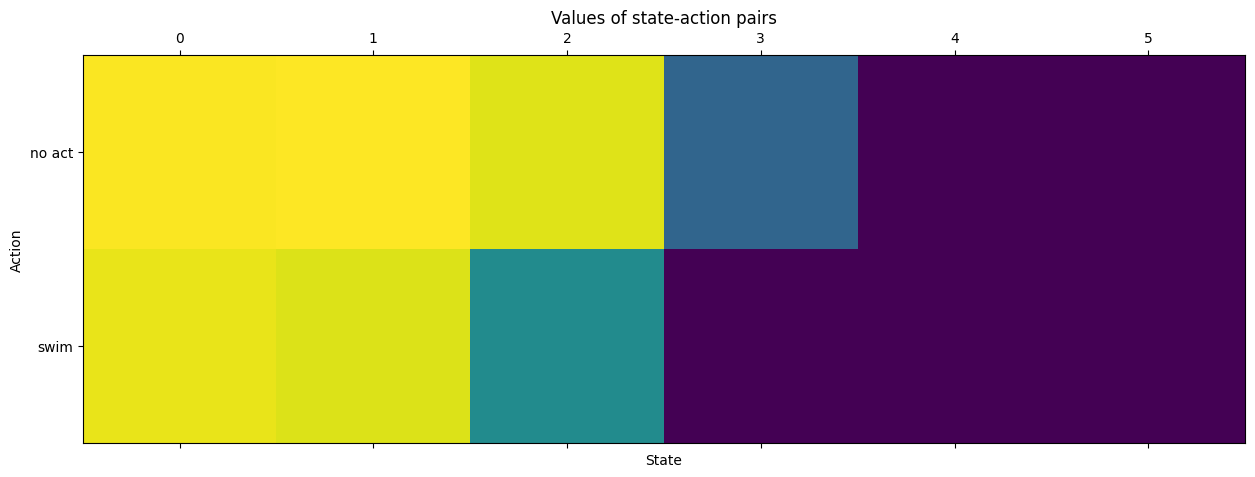

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.matshow(agent.get_q_matrix().T)
ax.set_yticklabels(['', 'no act', 'swim'])
plt.xlabel("State")
plt.ylabel("Action")
plt.title("Values of state-action pairs")
plt.show()

а здесь уже алгоритм решил дальше не плыть и оставаться в начальном состоянии

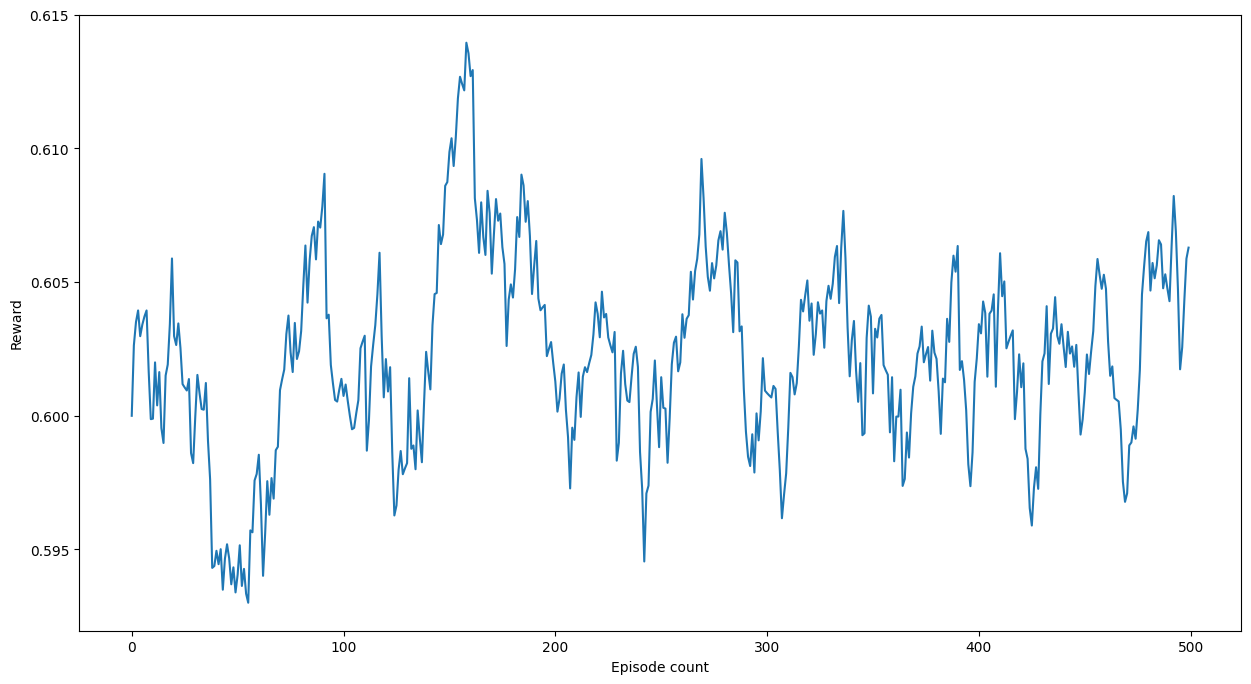

In [ ]:
n = 10
ms = 128
episodes = 500
actions = 2

agent = QLearningAgent(2+n, actions)

episode_rewards = []
for ep in range(episodes):
    river_swim = RiverSwim(n, ms)

    state, ep_reward, is_done = river_swim._current_state, 0.0, False
    agent.start_episode()
    while not is_done:
        action = agent.get_action(state)
        next_state, reward, is_done = river_swim.step(action)
        agent.update(state, action, reward, next_state)

        state = next_state
        ep_reward += reward

    episode_rewards.append(ep_reward)


plt.figure(figsize=(15, 8))

plt.plot(pd.DataFrame(np.array(episode_rewards)).ewm(alpha=.1).mean())
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

<ipython-input-22-3c99130bf45b>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'no act', 'swim'])


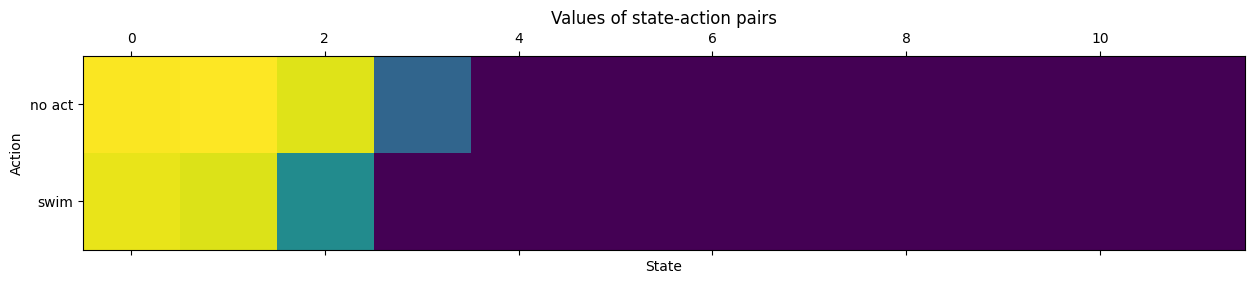

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.matshow(agent.get_q_matrix().T)
ax.set_yticklabels(['', 'no act', 'swim'])
plt.xlabel("State")
plt.ylabel("Action")
plt.title("Values of state-action pairs")
plt.show()

то же самое

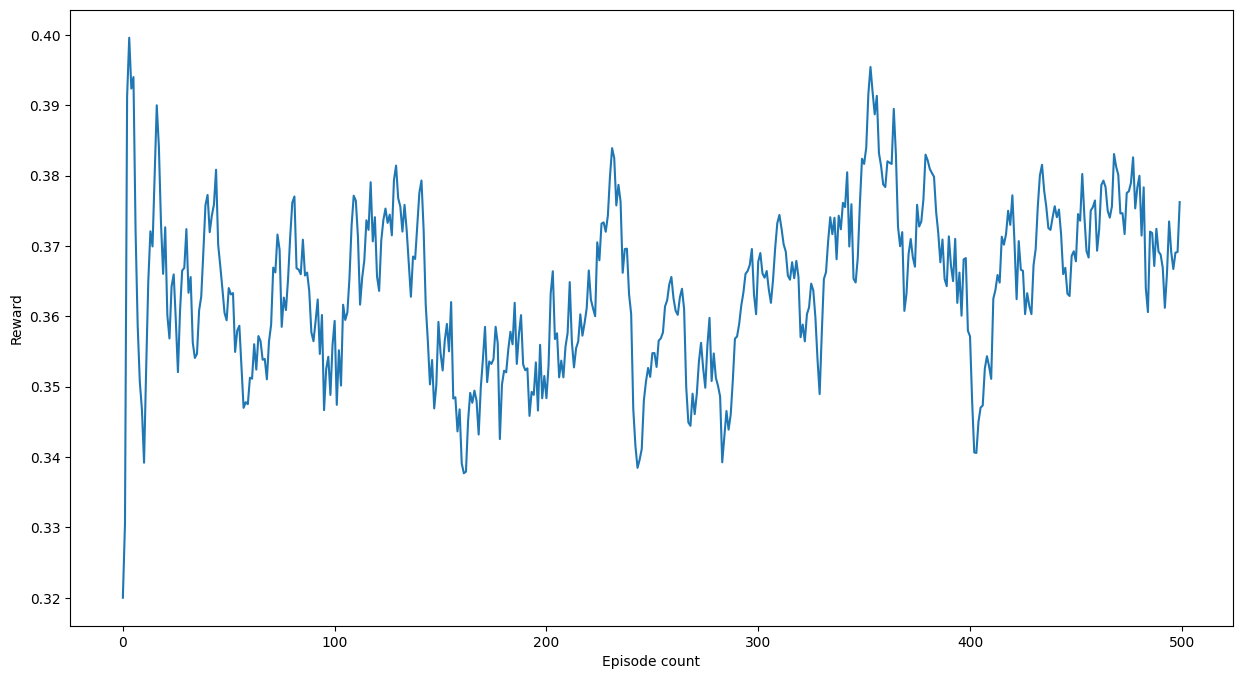

In [ ]:
n = 10
ms = 128
episodes = 500
actions = 2

agent = QLearningAgent(2+n, actions, epsilon=1)

episode_rewards = []
for ep in range(episodes):
    river_swim = RiverSwim(n, ms)

    state, ep_reward, is_done = river_swim._current_state, 0.0, False
    agent.start_episode()
    while not is_done:
        action = agent.get_action(state)
        next_state, reward, is_done = river_swim.step(action)
        agent.update(state, action, reward, next_state)

        state = next_state
        ep_reward += reward

    episode_rewards.append(ep_reward)


plt.figure(figsize=(15, 8))

plt.plot(pd.DataFrame(np.array(episode_rewards)).ewm(alpha=.1).mean())
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

<ipython-input-24-3c99130bf45b>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'no act', 'swim'])


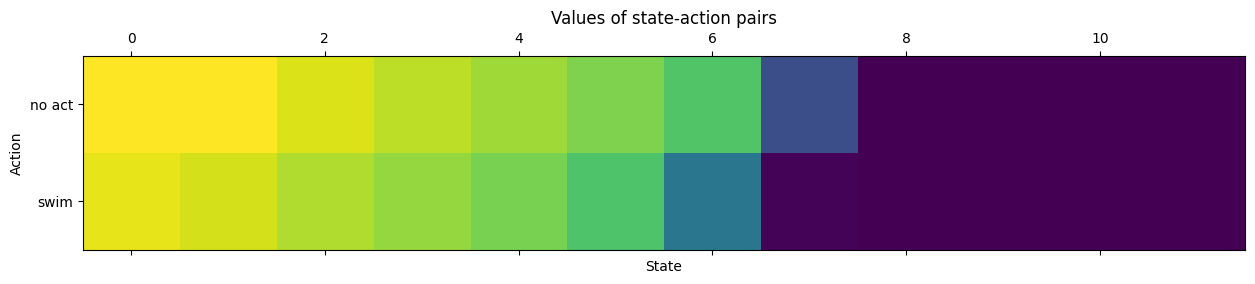

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.matshow(agent.get_q_matrix().T)
ax.set_yticklabels(['', 'no act', 'swim'])
plt.xlabel("State")
plt.ylabel("Action")
plt.title("Values of state-action pairs")
plt.show()

даже если выставить эпсилон в единицу не доплывает

# Теперь попробуем реализовать Posterior Sampling

идея состоит в том, чтобы смоделировать среду

In [6]:
class PosteriorSamplingLearningAgent:
    def __init__(self, n, K, lr=0.2, gamma=0.95, epsilon=0.2, seed=42):
        self.rs = np.random.RandomState(seed)
        self._gamma = gamma
        self._epsilon = epsilon
        self._q_matrix = np.zeros((n, K))
        self._lr = lr
        self.n = n

        self.T = np.ones((n, n, 2))
        self.mu = np.ones((n, 2))
        self.alpha = np.ones((n, 2))
        self.beta = np.ones((n, 2))
        self.nu =  np.ones((n,2))
        self.S = np.zeros_like(self.T)
        self.R = np.zeros_like(self.mu)
        self.V = np.zeros(n)

    def get_action(self, state):
        return np.argmax(self.R[state] + np.dot(self.S[state].T, self.V))

    def get_q_matrix(self):
      return self.R + np.dot(self.S.transpose(0,2,1), self.V)

    def start_episode(self):

        self.prev_states = []

        Sd = [[np.random.dirichlet(p) for p in T] for T in self.T.transpose(0,2,1)]

        self.S = np.array(Sd).reshape(self.n,2,self.n).transpose(0,2,1)

        #for i in range(n):
        #  for j in range(n):
        #      self.S[i, j] = np.random.dirichlet(self.T[i, j])

        self.R = norm.rvs(loc=self.mu, scale=1/np.sqrt(gamma.rvs(a=self.alpha, scale=1/self.beta, random_state=self.rs)*self.nu), random_state=self.rs)

        self.V = np.amax(self.R + np.dot(self.S.transpose(0,2,1), self.V), axis=1)
        return


    def update(self, state, action, reward, next_state): #с помощбю сопряженного распределения

      self.T[state, next_state, action] += 1

      self.alpha[state, action] += 0.5

      self.mu[state, action] = (self.nu[state, action] * self.mu[state, action] + reward)/(self.nu[state, action]+1)

      self.nu[state, action] += 1

      self.beta[state, action] += self.nu[state, action]/(self.nu[state, action]+1) * (reward - self.mu[state, action])**2 / 2


      return

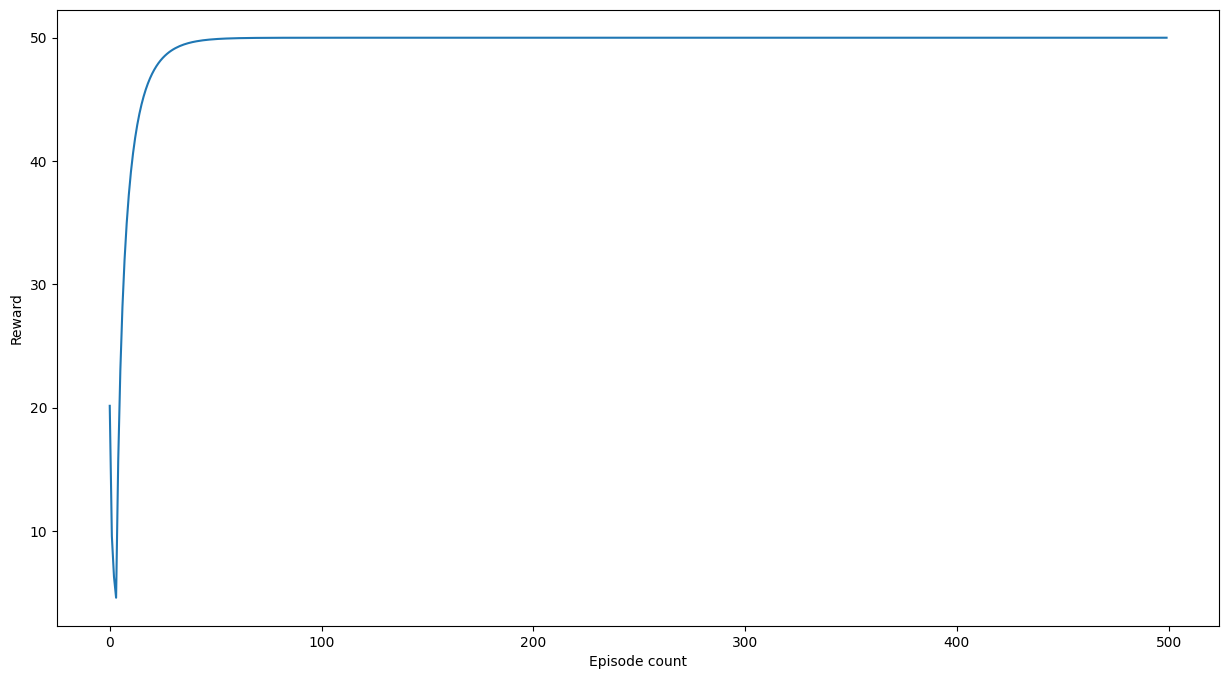

In [18]:
n = 2
ms = 128
episodes = 500
actions = 2

agent = PosteriorSamplingLearningAgent(2+n, actions)

episode_rewards = []
for ep in range(episodes):
    river_swim = RiverSwim(n, ms)

    state, ep_reward, is_done = river_swim._current_state, 0.0, False
    agent.start_episode()

    while not is_done:
        action = agent.get_action(state)
        next_state, reward, is_done = river_swim.step(action)
        agent.update(state, action, reward, next_state)

        state = next_state
        ep_reward += reward

    episode_rewards.append(ep_reward)

fig = plt.figure(figsize=(15, 8))
plt.plot(pd.DataFrame(np.array(episode_rewards)).ewm(alpha=.1).mean())
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

<ipython-input-19-3c99130bf45b>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'no act', 'swim'])


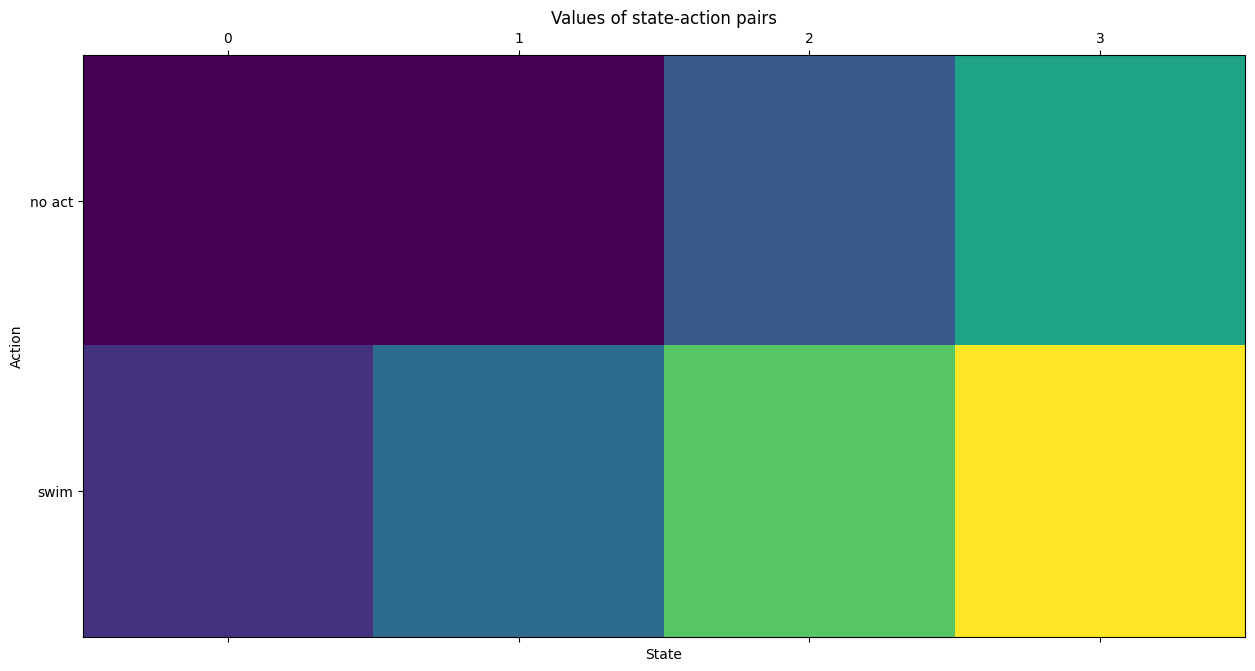

In [19]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.matshow(agent.get_q_matrix().T)
ax.set_yticklabels(['', 'no act', 'swim'])
plt.xlabel("State")
plt.ylabel("Action")
plt.title("Values of state-action pairs")
plt.show()

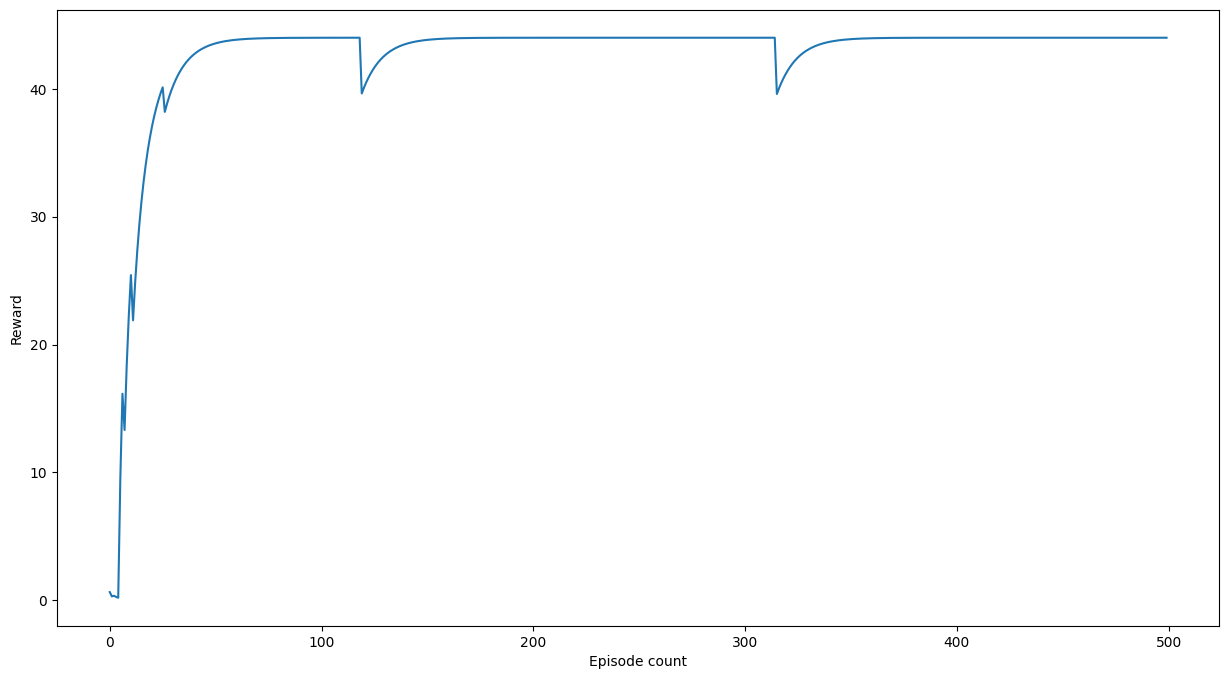

In [20]:
n = 5
ms = 128
episodes = 500
actions = 2

agent = PosteriorSamplingLearningAgent(2+n, actions)

episode_rewards = []
for ep in range(episodes):
    river_swim = RiverSwim(n, ms)

    state, ep_reward, is_done = river_swim._current_state, 0.0, False
    agent.start_episode()
    while not is_done:
        action = agent.get_action(state)
        next_state, reward, is_done = river_swim.step(action)
        agent.update(state, action, reward, next_state)

        state = next_state
        ep_reward += reward

    episode_rewards.append(ep_reward)


plt.figure(figsize=(15, 8))

plt.plot(pd.DataFrame(np.array(episode_rewards)).ewm(alpha=.1).mean())
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

<ipython-input-21-3c99130bf45b>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'no act', 'swim'])


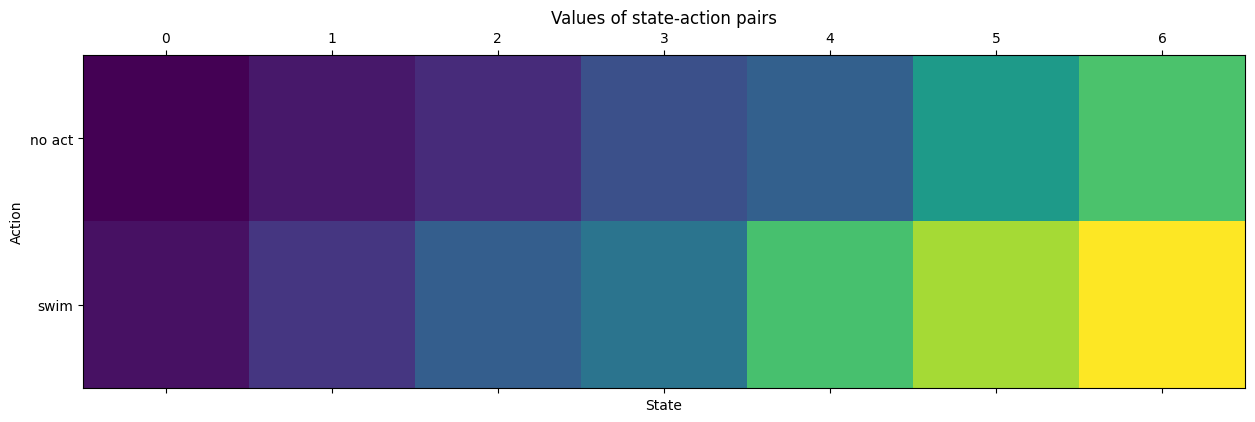

In [21]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.matshow(agent.get_q_matrix().T)
ax.set_yticklabels(['', 'no act', 'swim'])
plt.xlabel("State")
plt.ylabel("Action")
plt.title("Values of state-action pairs")
plt.show()

ураа доплыл

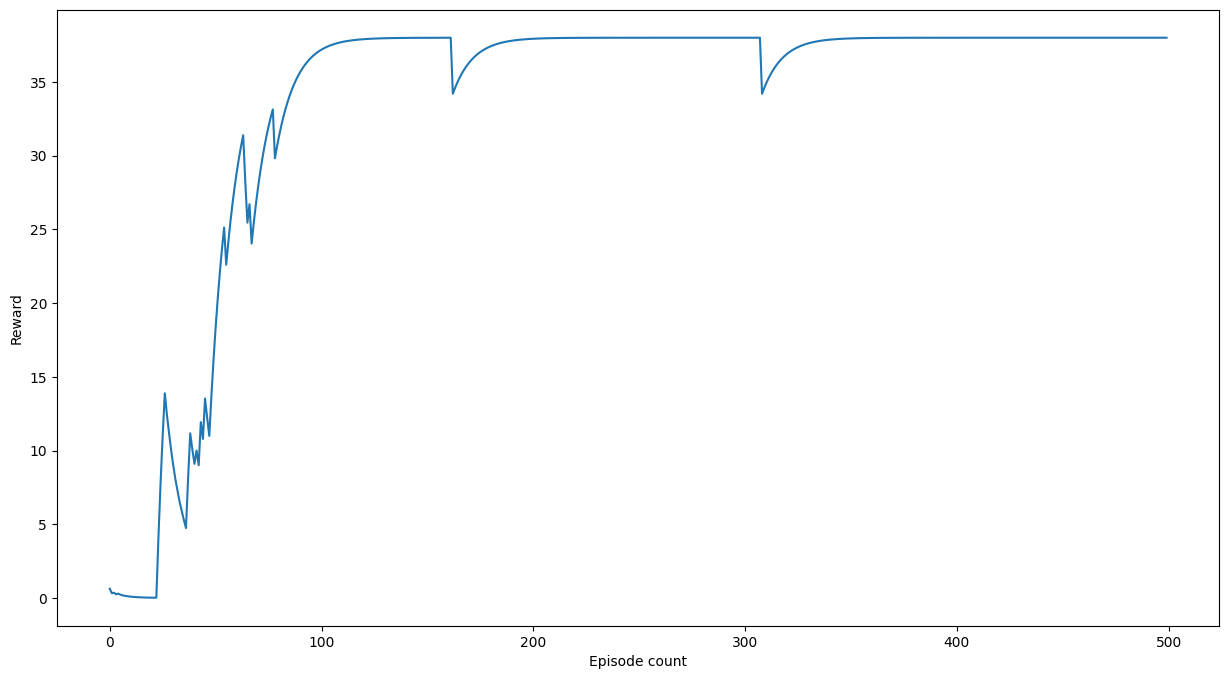

In [24]:
n = 10
ms = 128
episodes = 500
actions = 2

agent = PosteriorSamplingLearningAgent(2+n, actions)

episode_rewards = []
for ep in range(episodes):
    river_swim = RiverSwim(n, ms)

    state, ep_reward, is_done = river_swim._current_state, 0.0, False
    agent.start_episode()
    while not is_done:
        action = agent.get_action(state)
        next_state, reward, is_done = river_swim.step(action)
        agent.update(state, action, reward, next_state)

        state = next_state
        ep_reward += reward

    episode_rewards.append(ep_reward)


plt.figure(figsize=(15, 8))

plt.plot(pd.DataFrame(np.array(episode_rewards)).ewm(alpha=.1).mean())
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

<ipython-input-25-3c99130bf45b>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'no act', 'swim'])


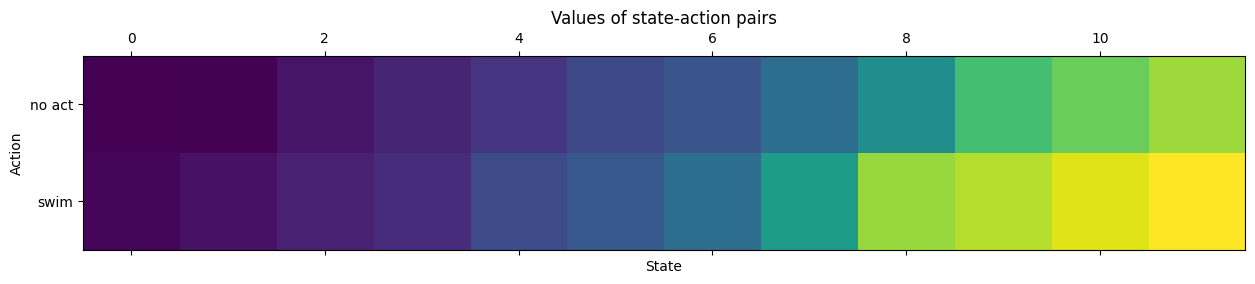

In [25]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.matshow(agent.get_q_matrix().T)
ax.set_yticklabels(['', 'no act', 'swim'])
plt.xlabel("State")
plt.ylabel("Action")
plt.title("Values of state-action pairs")
plt.show()

Таким образом PS агент действительно работает лучше чем Q агент (быстрее обучается и доплывает до конца). Выбирая плыть дальше агент в конечном счете получает большее вознаграждение